# Convolutional Neural Networks on CIFAR10 dataset

- CIFAR-10 is a dataset that consists of several images divided into the following 10 classes:
    - Airplanes
    - Cars
    - Birds
    - Cats
    - Deer
    - Dogs
    - Frogs
    - Horses
    - Ships
    - Trucks

- The dataset stands for the Canadian Institute For Advanced Research (CIFAR)
- CIFAR-10 is widely used for machine learning and computer vision applications.
- The dataset consists of 60,000 32x32 color images and 6,000 images of each class.
- Images have low resolution (32x32).
- Data Source: https://www.cs.toronto.edu/~kriz/cifar.html

The Challenge here for the model is extreme low resolutions of the images

## Library imports

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

from sklearn.metrics import confusion_matrix, classification_report

In [46]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Load the Dataset

In [47]:
# load the data
(features_train, target_train), (features_test, target_test) = cifar10.load_data()
# Let's check the shape of the respective sets
print(f"Shape of the Training features: {features_train.shape}")
print(f"Shape of the Testing features: {features_test.shape}")
print(f"Shape of the Training labels: {target_train.shape}")
print(f"Shape of the Testing labels: {target_test.shape}")

Shape of the Training features: (50000, 32, 32, 3)
Shape of the Testing features: (10000, 32, 32, 3)
Shape of the Training labels: (50000, 1)
Shape of the Testing labels: (10000, 1)


## Data Visualizations

Class of the image - [9]


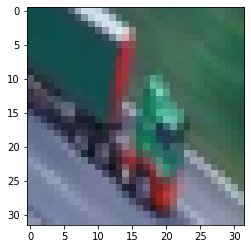

In [48]:
# We will check the 50th image
plt.imshow(features_train[50])
print(f"Class of the image - {target_train[50]}")

/Users/suvosmac/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


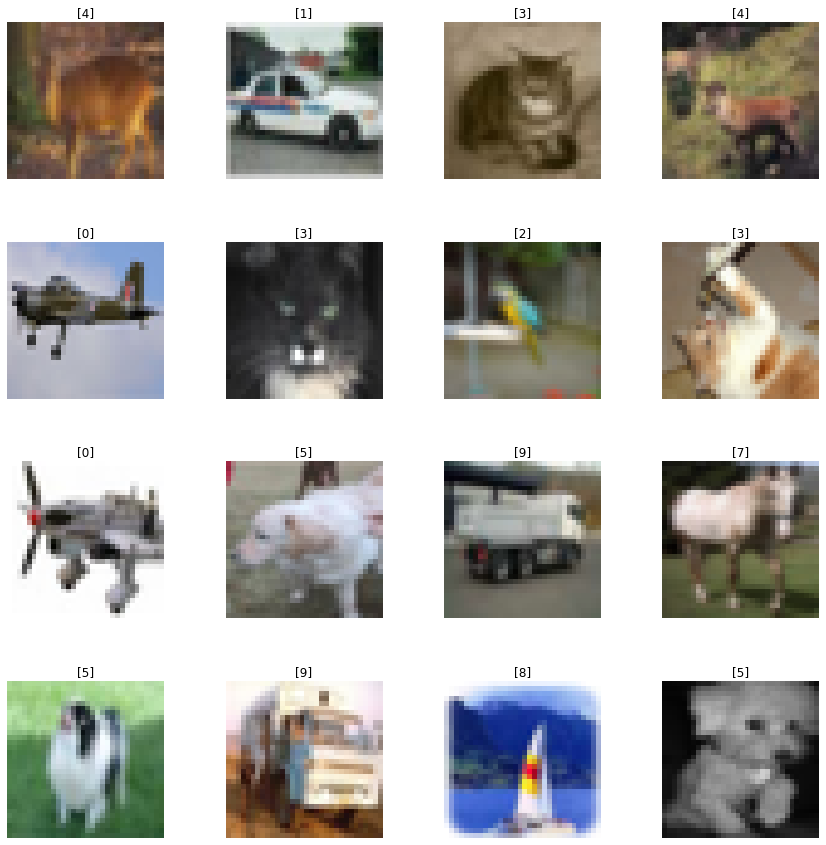

In [49]:
# Lets view some 16 images

W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes = axes.ravel()

n_training = len(features_train)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(features_train[index])
    axes[i].set_title(target_train[index])
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

## Data Preparation for CNN

In [50]:
# We will need to convert the datatypes of training and testing features to float32
features_train = features_train.astype('float32')
features_test = features_test.astype('float32')

In [51]:
# Normalize the training and test features
features_train = features_train/255
features_test = features_test/255

In [52]:
# In order to use categorical cross entropy, we need to convert the target variable to categorical
target_train = tf.keras.utils.to_categorical(target_train, num_classes=10)
target_test = tf.keras.utils.to_categorical(target_test, num_classes=10)

In [53]:
# Check the training features
features_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [54]:
# Check the training target
target_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Build and Train the Model

In [55]:
# Build the Model
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.keras.activations.relu, input_shape=features_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.keras.activations.relu))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(tf.keras.layers.Dropout(0.3))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(tf.keras.layers.Dropout(0.3))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1024, activation=tf.keras.activations.relu))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.Dense(units=1024, activation=tf.keras.activations.relu))
cnn.add(tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax))

# Compile the Model
cnn.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)         

In [56]:
# Train the Model
start = datetime.datetime.now()
print(f"Training Begins at - {start}")
print("\n")
cnn.fit(features_train, target_train, batch_size=512, epochs=100)
print("\n")
end = datetime.datetime.now()
print(f"Training ends at - {end}")
print(f"Total Training time - {end - start}")

Training Begins at - 2022-07-17 15:41:58.203133


Epoch 1/100
98/98 [==============================] - 41s 419ms/step - loss: 2.1956 - accuracy: 0.1688
Epoch 2/100
98/98 [==============================] - 42s 424ms/step - loss: 1.7480 - accuracy: 0.3627
Epoch 3/100
98/98 [==============================] - 42s 424ms/step - loss: 1.5889 - accuracy: 0.4180
Epoch 4/100
98/98 [==============================] - 42s 424ms/step - loss: 1.4780 - accuracy: 0.4632
Epoch 5/100
98/98 [==============================] - 42s 431ms/step - loss: 1.4069 - accuracy: 0.4945
Epoch 6/100
98/98 [==============================] - 45s 461ms/step - loss: 1.3514 - accuracy: 0.5145
Epoch 7/100
98/98 [==============================] - 46s 464ms/step - loss: 1.3128 - accuracy: 0.5321
Epoch 8/100
98/98 [==============================] - 47s 476ms/step - loss: 1.2687 - accuracy: 0.5479
Epoch 9/100
98/98 [==============================] - 47s 477ms/step - loss: 1.2373 - accuracy: 0.5596
Epoch 10/100
98/98 [============

## Model Evaluation

In [58]:
# We will analyse the two keys of the model
cnn.history.history.keys()

dict_keys(['loss', 'accuracy'])

Text(0.5, 1.0, 'Training Accuracy')

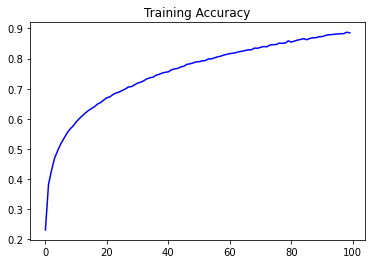

In [62]:
# Plot training accuracy throughout the model
epochs = range(len(cnn.history.history['accuracy']))
plt.plot(epochs, cnn.history.history['accuracy'], 'b', label='Training Accuracy')
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Training Loss')

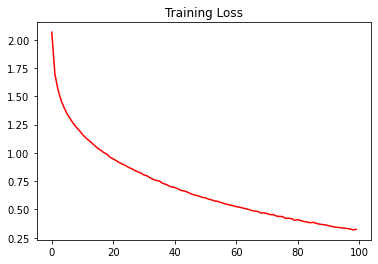

In [63]:
# We will now plot the training Loss
epochs = range(len(cnn.history.history['loss']))
plt.plot(epochs, cnn.history.history['loss'], 'r', label='Training Loss')
plt.title("Training Loss")

In [64]:
# Find the accuracy on the overall test features (images)
score = cnn.evaluate(features_test, target_test, verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 0.7443 - accuracy: 0.7688


In [65]:
print(f"Test Accuracy - {score[1]}")

Test Accuracy - 0.7688000202178955


In [67]:
# Now we will run the prediction of classes
predicted_classes = cnn.predict_classes(features_test)

/Users/suvosmac/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [68]:
predicted_classes

array([5, 8, 8, ..., 5, 0, 7])

In [69]:
# Convert back to labels from categories matrix
target_test = target_test.argmax(axis=1)
target_test

array([3, 8, 8, ..., 5, 1, 7])

Print the Confusion Matrix

[[789  18  22  10  16   4  11   6  78  46]
 [  6 887   3   4   2   2   9   1  27  59]
 [ 68   7 632  49  75  49  66  18  23  13]
 [ 21  13  56 533  56 176  63  36  16  30]
 [ 16   3  56  46 755  22  45  43   9   5]
 [ 13   3  29 136  57 672  39  40   6   5]
 [  5   4  30  32  17  15 886   0   7   4]
 [ 13   4  25  33  51  48  11 790   3  22]
 [ 37  32   8   7   4   2   8   1 868  33]
 [ 20  54   4   4   3   6   7   4  22 876]]


<AxesSubplot:>

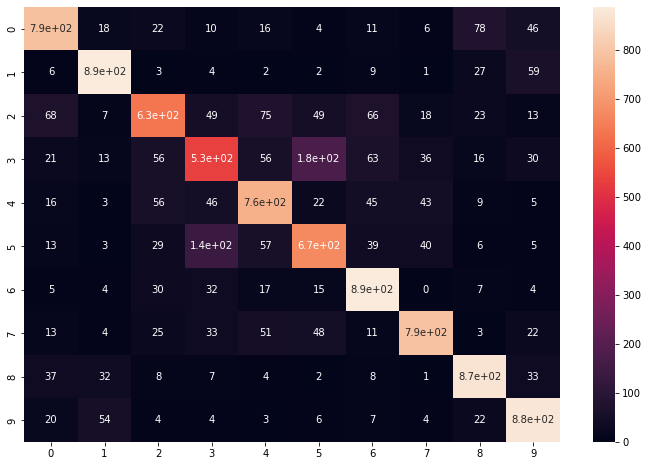

In [70]:
print(f"Print the Confusion Matrix\n")
cm = confusion_matrix(target_test, predicted_classes)
print(cm)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True)

In [71]:
print("Classification Report\n")
print(classification_report(target_test, predicted_classes))

Classification Report

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1000
           1       0.87      0.89      0.88      1000
           2       0.73      0.63      0.68      1000
           3       0.62      0.53      0.57      1000
           4       0.73      0.76      0.74      1000
           5       0.67      0.67      0.67      1000
           6       0.77      0.89      0.83      1000
           7       0.84      0.79      0.81      1000
           8       0.82      0.87      0.84      1000
           9       0.80      0.88      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

